# Resource vs Utility

* Eventually, we want a curve of resource vs utility
* We can get intermediate resource vs latency curve
* multiple ways to convert latency to utility
  * find the average of frame utility
  * take the 90th percentile of frame utility
  
## Optimization problem formulation

* max sum of u(c,m) subject to sum c <= c_total, sum m <= m_total
* the utility function may not be convex, therefore not able to solve it efficiently in polynomial time
* use iterative random search or gradient descent to find local optimal

In [5]:
from __future__ import absolute_import, division, print_function

import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize

from rmexp import dbutils, schema
#from rmexp.utilityfunc import app_default_utility_func

In [6]:
import scipy

def create_latency_sigmoid(lo_x, hi_x, lo_y=0.9, hi_y=0.99):
    # y = 1 / (1 + exp^(ax-b))
    # => xa - b = ln(1/y - 1)
    a, b = np.linalg.solve([[lo_x, -1], [hi_x, -1]],
                           np.log([1./lo_y - 1, 1./hi_y - 1]))
    return lambda x: 1. / (1. + np.exp(a*x - b))

def get_slow_exponential(slow_decay_st, expo_decay_st, half_life):
    slow_decay_st, expo_decay_st, half_life = map(float, 
                                                  [slow_decay_st, expo_decay_st, half_life])
    exponential_lambda = np.log(2.) / half_life
    # 1 - (x/a)^n
    slow_n = 4.0
    slow_a = (expo_decay_st - slow_decay_st) / np.power(1 - 0.9, 1 / slow_n)
    def util_one(x):
        if x <= slow_decay_st:
            return 1.0
        elif x > slow_decay_st and x <= expo_decay_st:
            return 1 - np.power( (x-slow_decay_st) / slow_a, 4)
        else:
            # exponential decay
            return 0.9 * np.exp(-exponential_lambda * (x-expo_decay_st))
    return util_one

lego_util = get_slow_exponential(600, 2700, (2700-600)/4.0)   

# Based on Zhuo's SEC'17
app_default_utility_func = {
    'lego':  get_slow_exponential(600, 2700, (2700-600)/4.0),
    'pingpong': get_slow_exponential(150, 230, (230-150)/8.0), # decay twice faster
    'pool': get_slow_exponential(95, 105, (105-95)/4.0),
    'face': get_slow_exponential(370, 1000, (1000-370)/4.0),    
#    'face': create_latency_sigmoid(370, 1000),
}

<IPython.core.display.Javascript object>


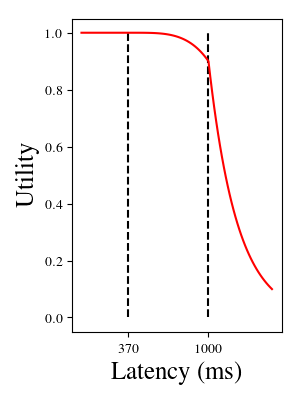

<IPython.core.display.Javascript object>


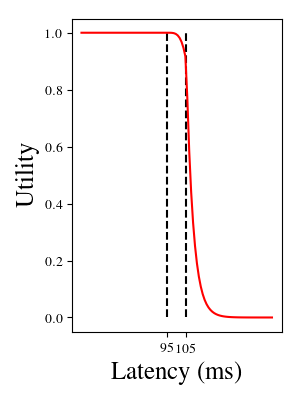

In [57]:
%matplotlib notebook

x = np.linspace(0, 1500, 100)
plt.figure(figsize=(3,4))
plt.plot(x, map(app_default_utility_func['face'], x), 'r-')
plt.vlines([370, 1000], 0., 1., linestyles='dashed')
plt.xticks([370, 1000])
plt.xlabel('Latency (ms)', fontsize=18)
plt.ylabel('Utility', fontsize=18)
plt.tight_layout()
plt.savefig('fig-lat-util-%s.pdf' % 'face', bbox_inches='tight')

x = np.linspace(50, 150, 100)
plt.figure(figsize=(3,4))
plt.plot(x, map(app_default_utility_func['pool'], x), 'r-')
plt.vlines([95, 105], 0., 1., linestyles='dashed')
plt.xticks([95, 105])
plt.xlabel('Latency (ms)', fontsize=18)
plt.ylabel('Utility', fontsize=18)
plt.tight_layout()
plt.savefig('fig-lat-util-%s.pdf' % 'pool', bbox_inches='tight')

<IPython.core.display.Javascript object>


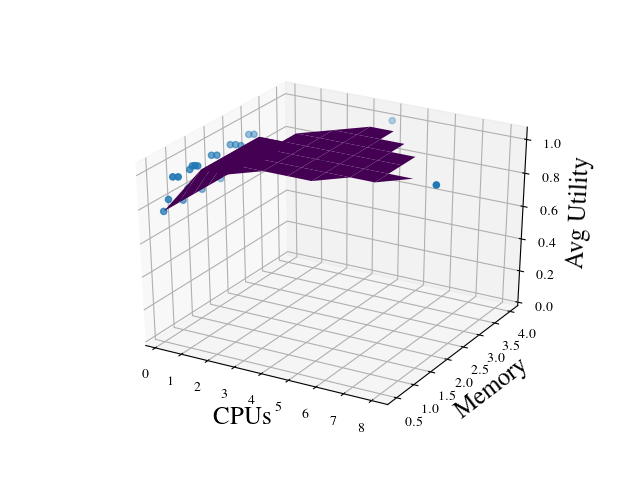

lego Profile
0.2 8.0


<IPython.core.display.Javascript object>


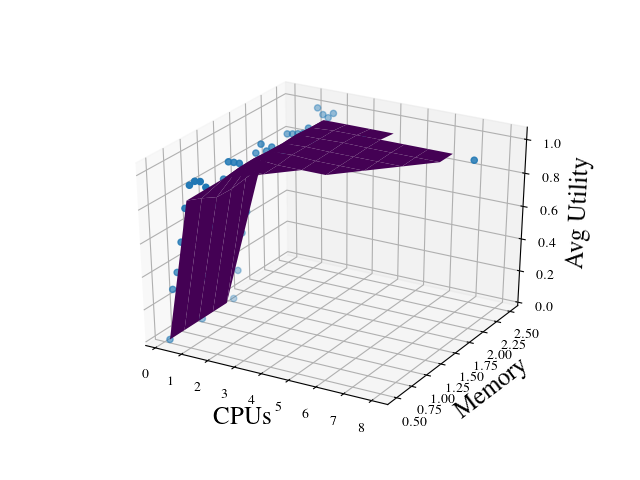

pingpong Profile
0.2 8.0


<IPython.core.display.Javascript object>


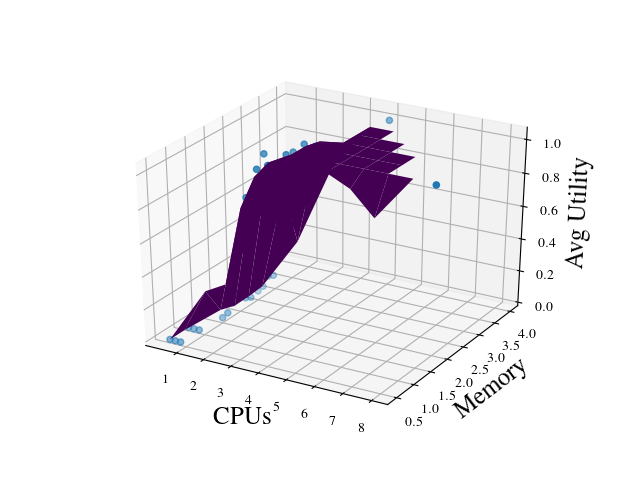

pool Profile
0.4 8.0


<IPython.core.display.Javascript object>


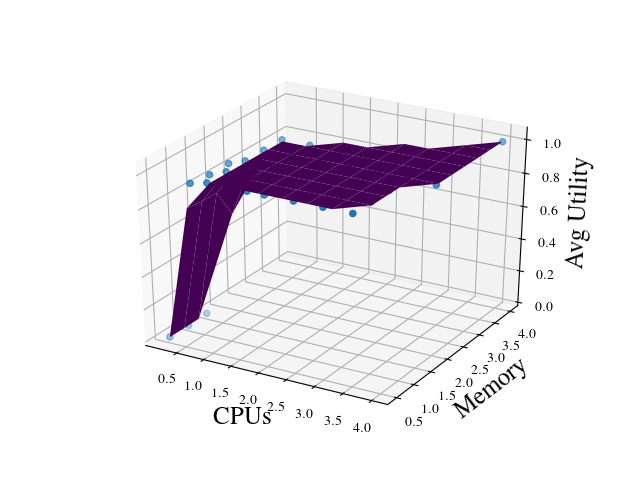

face Profile
0.2 4.0


In [50]:
from mpl_toolkits.mplot3d import Axes3D
import scipy.interpolate
import cPickle as pickle

class ResourceToLatency(object):
    def __init__(self, app, l2u_func=None):
        self.app = app
        self.l2u_func = l2u_func
        self._df = self._get_df_by_latency()
        self.func = None
        # fit cpu
        # scipy fit is very sensitive to initial parameters
#         (a, b, c, d), _ = scipy.optimize.curve_fit(lambda x,a,b,c,d: a*np.exp(d*x+b)+c, 
#                                                 self._df['cpu'].values, 
#                                                 self._df['mean_latency'].values,
#                                                 p0=[200, 2, 50, -2]
#                                                )
#         print(a,b,c,d)
#         self.predict_cpu = lambda x: a*np.exp(d*x+b)+c
    
    def _get_df_by_avg_latency(self):
        return pd.read_sql(
            'select avg(latency) as mean_latency, cpu, memory from ResourceLatency where trace like %(app)s group by trace, cpu, memory',
            schema.engine,
            params={'app': self.app+'%'}
        )
    
    def _get_df_by_latency(self):
        """Get dataframe by converting latency to utility frame by frame"""
        df = pd.read_sql(
            'select latency, cpu, memory from ResourceLatency where trace like %(app)s',
            schema.engine,
            params={'app': self.app+'%'}
        )
        if self.l2u_func is not None:
            df['util'] = df['latency'].apply(self.l2u_func)
        return df
        
    def __call__(self, cpu, **kwargs):
        return self.predict_cpu(cpu)
        
    def print_profile(self):
        print(self._df)
        
    def plot_cpu(self, plt, memory=2, fmt='o'):
        plt.plot('cpu', 'mean_latency', fmt, data=self._df[self._df['memory']==2], label=self.app)
    
    def plot_util(self):
        groups = self._df.groupby(['cpu', 'memory'])
        cpus = np.array([name[0] for name, _ in groups])
        mems = np.array([name[1] for name, _ in groups])
        util_avgs = np.array([group['util'].mean() for _, group in groups])

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter(cpus, mems, util_avgs)
        ax.set_xlabel('CPUs', fontsize=18)
        ax.set_ylabel('Memory', fontsize=18)
        ax.set_zlabel('Avg Utility', fontsize=18)
        ax.set_zlim([0, 1.05])
        for (x, y, z) in zip(cpus, mems, util_avgs):
            pt_txt = '{}'.format((round(x, 2), round(y, 2),round(z, 2)))
#             print(pt_txt)
#             ax.text(x, y, z,  pt_txt, size=10, zorder=1, color='k')
#        ax.set_title('{} Profile'.format(self.app))
        print('{} Profile'.format(self.app))
    
        # interpolation fitting
        interpolated_func = scipy.interpolate.LinearNDInterpolator(zip(cpus, mems), util_avgs)
        print(np.min(cpus), np.max(cpus))
        xp = np.linspace(np.min(cpus), np.max(cpus), 10)
        yp = np.linspace(np.min(mems), np.max(mems), 10)
        xp, yp = np.meshgrid(xp, yp)
        zp = interpolated_func(xp, yp)
        self.func = interpolated_func
        ax.plot_surface(xp, yp, zp, cmap='viridis', edgecolor='none')
        plt.savefig('fig-app-profile-{}.pdf'.format(self.app), bbox_inches='tight')
    
    def save_func(self):
        pickle.dump(self.func, open("profile/{}.pkl".format(self.app), "wb"), -1)        

    
legop = ResourceToLatency('lego', app_default_utility_func['lego'])
pingpongp = ResourceToLatency('pingpong', app_default_utility_func['pingpong'])
poolp = ResourceToLatency('pool', app_default_utility_func['pool'])
facep = ResourceToLatency('face', app_default_utility_func['face'])
legop.plot_util()
pingpongp.plot_util()
poolp.plot_util()
facep.plot_util()

In [46]:
# save interpolated func
map(lambda x: x.save_func(), [legop, pingpongp, poolp, facep])

[None, None, None, None]

In [ ]:
## iterative random search

In [46]:
legop = ResourceToLatency('lego')
pingpongp = ResourceToLatency('pingpong')
poolp = ResourceToLatency('pool')
poolp.print_profile()

159.78876945 2.3526938731 112.969324963 -2.12329980683
657.504374695 -0.193646495157 31.6264004335 -1.45224465067
227.326144942 2.13587512615 44.3257277065 -2.61532828331
   mean_latency  cpu  memory
0    185.069721    1       2
1     54.591568    2       2
2     42.363702    4       2
3     48.180192    4       4
4     42.570650    8       2


<IPython.core.display.Javascript object>


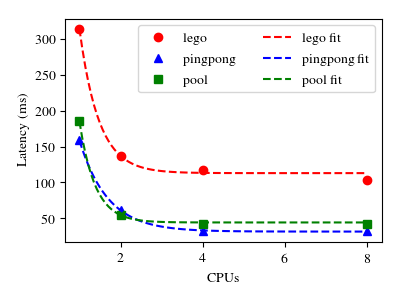

In [50]:
plt.figure(figsize=(4,3))
legop.plot_cpu(plt, fmt='ro')
pingpongp.plot_cpu(plt, fmt='b^')
poolp.plot_cpu(plt, fmt='gs')

# # fit lego
# (a, b, c, d), _ = scipy.optimize.curve_fit(lambda x,a,b,c,d: c*np.exp(-1*(x+a)) +b, legop._df['cpu'].values, legop._df['mean_latency'].values)
# print(a, b, c, d)

x = np.linspace(1, 8, 100)
plt.plot(x, legop(x), 'r--', label='lego fit')
plt.plot(x, pingpongp(x), 'b--', label='pingpong fit')
plt.plot(x, poolp(x), 'g--', label='pool fit')
plt.xlabel('CPUs')
plt.ylabel('Latency (ms)')

plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('fig-res-lat.pdf', bbox_inches='tight')

In [51]:
class ResourceToUtility(object):
    def __init__(self, res_to_lat, lat_to_util):
        self.res_to_lat = res_to_lat
        self.lat_to_util = lat_to_util
        
    def __call__(self, cpu, **kwargs):
        return self.lat_to_util(self.res_to_lat(cpu, **kwargs))

<IPython.core.display.Javascript object>


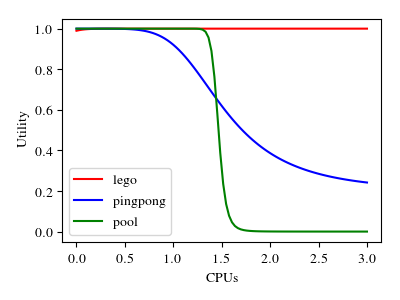

159.78876945 2.3526938731 112.969324963 -2.12329980683
657.504374695 -0.193646495157 31.6264004335 -1.45224465067
227.326144942 2.13587512615 44.3257277065 -2.61532828331


In [52]:
plt.figure(figsize=(4,3))
cpus = np.linspace(0,3,100)
for app, c in [('lego', 'r'), ('pingpong', 'b'), ('pool', 'g')]:
    uf = ResourceToUtility(ResourceToLatency(app),
                           app_default_utility_func[app])
    plt.plot(cpus, uf(cpus), c+'-', label=app)

plt.legend()
plt.xlabel("CPUs")
plt.ylabel("Utility")
plt.tight_layout()
plt.savefig('fig-res-util.pdf', bbox_inches='tight')